In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
from cmcrameri import cm
from matplotlib import colors
import matplotlib.patches as patches
from scipy import signal
import peakutils
import math
from ms_deisotope import deconvolute_peaks, averagine, scoring
from ms_deisotope.deconvolution import peak_retention_strategy

In [160]:
EXPERIMENT_NAME = 'P3856'
RUN_NAME = 'YHE211_1'
precursor_id = 63178

In [161]:
before_df = pd.read_csv('/home/ubuntu/ms1-before-intensity-descent-precursor-{}.csv'.format(precursor_id))
after_df = pd.read_csv('/home/ubuntu/ms1-after-intensity-descent-precursor-{}.csv'.format(precursor_id))

In [162]:
before_df['normalised_intensity'] = before_df.intensity / before_df.intensity.max()
after_df['normalised_intensity'] = after_df.intensity / after_df.intensity.max()

In [163]:
metadata_df = pd.read_csv('/home/ubuntu/metadata-precursor-{}.csv'.format(precursor_id))
metadata_s = metadata_df.iloc[0]
metadata_s

Unnamed: 0                0.000000
precursor_id          63178.000000
window_mz_lower        1480.852318
window_mz_upper        1483.285443
wide_mz_lower          1479.848963
wide_mz_upper          1483.285443
window_scan_width        77.000000
fe_scan_lower           179.000000
fe_scan_upper           256.000000
wide_scan_lower         179.000000
wide_scan_upper         256.000000
wide_rt_lower          1907.966193
wide_rt_upper          1917.966193
fe_ms1_frame_lower    17042.000000
fe_ms1_frame_upper    17142.000000
fe_ms2_frame_lower             NaN
fe_ms2_frame_upper             NaN
wide_frame_lower      17042.000000
wide_frame_upper      17142.000000
number_of_windows         1.000000
Name: 0, dtype: float64

In [164]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

# Rescale to values between 0 and 1
tableau20_mpl = tableau20.copy()
for i in range(len(tableau20_mpl)):  
    r, g, b = tableau20_mpl[i]  
    tableau20_mpl[i] = (r / 255., g / 255., b / 255.)

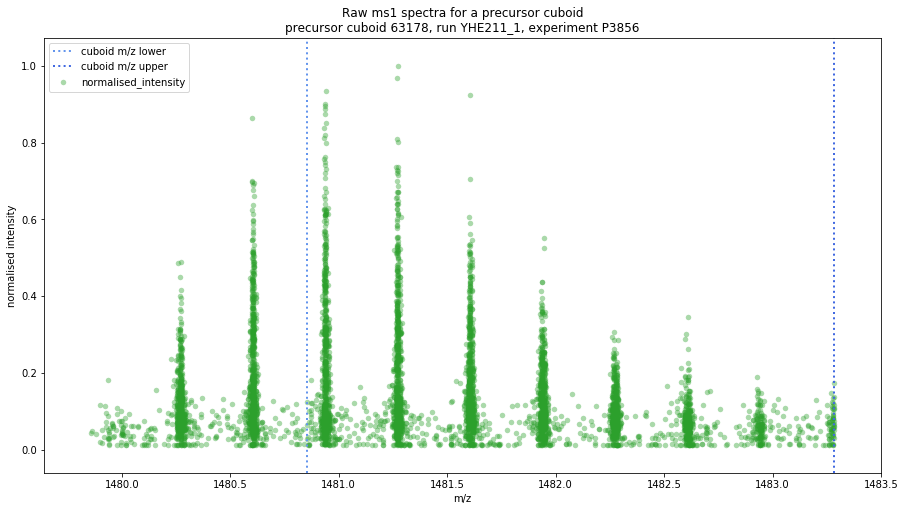

In [186]:
f, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

ax.scatter(before_df.mz, before_df.normalised_intensity, marker='o', color='tab:green', lw=0, s=30, alpha=0.4)

plt.xlabel('m/z')
plt.ylabel('normalised intensity')
f.set_figheight(8)
f.set_figwidth(15)

nearest = 0.5
range_l = round(before_df.mz.min() / nearest) * nearest
range_u = round(before_df.mz.max() / nearest) * nearest
plt.xticks(np.arange(range_l,range_u+nearest,nearest))

plt.axvline(x=metadata_s.window_mz_lower, linestyle=':', color='cornflowerblue', linewidth=2, label='cuboid m/z lower')
plt.axvline(x=metadata_s.window_mz_upper, linestyle=':', color='royalblue', linewidth=2, label='cuboid m/z upper')

plt.margins(0.06)
plt.legend(loc='best')
plt.title('Raw ms1 spectra for a precursor cuboid\nprecursor cuboid {}, run {}, experiment {}'.format(precursor_id, RUN_NAME, EXPERIMENT_NAME))
plt.show()

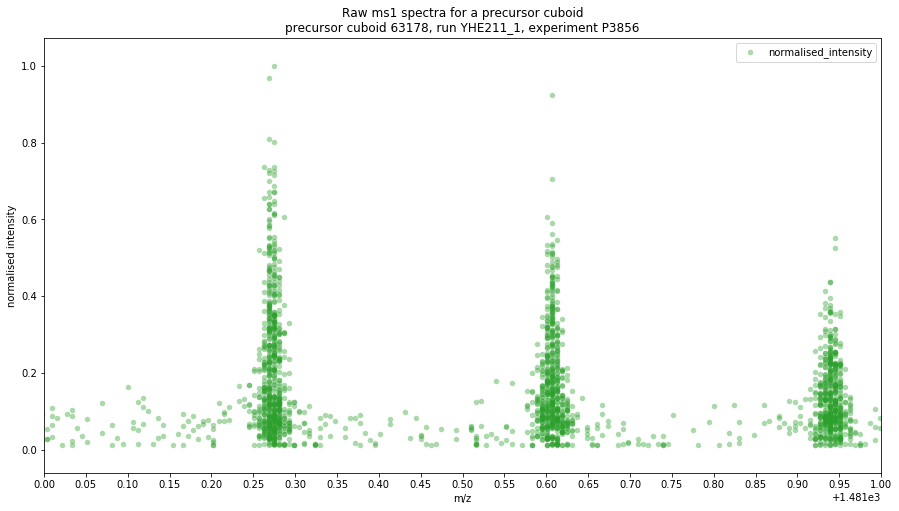

In [166]:
f, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

ax.scatter(before_df.mz, before_df.normalised_intensity, marker='o', color='tab:green', lw=0, s=30, alpha=0.4)

plt.xlabel('m/z')
plt.ylabel('normalised intensity')
f.set_figheight(8)
f.set_figwidth(15)

nearest = 0.05
range_l = round(before_df.mz.min() / nearest) * nearest
range_u = round(before_df.mz.max() / nearest) * nearest
plt.xticks(np.arange(range_l,range_u+nearest,nearest))

plt.xlim((1481,1482))

plt.margins(0.06)
plt.legend(loc='best')
plt.title('Raw ms1 spectra for a precursor cuboid\nprecursor cuboid {}, run {}, experiment {}'.format(precursor_id, RUN_NAME, EXPERIMENT_NAME))
plt.show()

In [190]:
# fe_raw_points_df = before_df[(before_df.mz >= metadata_s.window_mz_lower) & (before_df.mz <= metadata_s.window_mz_upper) & (before_df.frame_id >= metadata_s.fe_ms1_frame_lower) & (before_df.frame_id <= metadata_s.fe_ms1_frame_upper)]
fe_raw_points_df = before_df[(before_df.mz >= metadata_s.wide_mz_lower) & (before_df.mz <= metadata_s.wide_mz_upper) & (before_df.frame_id >= metadata_s.fe_ms1_frame_lower) & (before_df.frame_id <= metadata_s.fe_ms1_frame_upper)]
fe_raw_points_a = fe_raw_points_df[['mz','intensity']].to_numpy()

In [191]:
def calculate_ms1_peak_delta(mz):
    instrument_resolution = 40000
    delta_m = mz / instrument_resolution  # FWHM of the peak
    sigma = delta_m / 2.35482  # std dev is FWHM / 2.35482. See https://en.wikipedia.org/wiki/Full_width_at_half_maximum
    ms1_peak_delta = 3 * sigma  # 99.7% of values fall within +/- 3 sigma
    return ms1_peak_delta

In [192]:
calculate_ms1_peak_delta(1483)

0.04723290952174688

In [193]:
# takes a numpy array of intensity, and another of mz
def mz_centroid(_int_f, _mz_f):
    return ((_int_f/_int_f.sum()) * _mz_f).sum()

In [194]:
# ms1_peaks_a is a numpy array of [mz,intensity]
# returns a numpy array of [mz_centroid,summed_intensity]
def ms1_intensity_descent(ms1_peaks_a, ms1_peak_delta):
    # intensity descent
    ms1_peaks_l = []
    while len(ms1_peaks_a) > 0:
        # find the most intense point
        max_intensity_index = np.argmax(ms1_peaks_a[:,1])
        peak_mz = ms1_peaks_a[max_intensity_index,0]
        peak_mz_lower = peak_mz - ms1_peak_delta
        peak_mz_upper = peak_mz + ms1_peak_delta

        # get all the raw points within this m/z region
        peak_indexes = np.where((ms1_peaks_a[:,0] >= peak_mz_lower) & (ms1_peaks_a[:,0] <= peak_mz_upper))[0]
        if len(peak_indexes) > 0:
            mz_cent = mz_centroid(ms1_peaks_a[peak_indexes,1], ms1_peaks_a[peak_indexes,0])
            summed_intensity = ms1_peaks_a[peak_indexes,1].sum()
            ms1_peaks_l.append((mz_cent, summed_intensity))
            # remove the raw points assigned to this peak
            ms1_peaks_a = np.delete(ms1_peaks_a, peak_indexes, axis=0)
    return np.array(ms1_peaks_l)

In [195]:
peaks_variable_bins_a = ms1_intensity_descent(fe_raw_points_a, calculate_ms1_peak_delta(fe_raw_points_df.iloc[0].mz.max()))
peaks_variable_bins_df = pd.DataFrame(peaks_variable_bins_a, columns=['mz','intensity'])
peaks_variable_bins_df['normalised_intensity'] = peaks_variable_bins_df.intensity / peaks_variable_bins_df.intensity.max()

In [196]:
peaks_fixed_bins_a = ms1_intensity_descent(fe_raw_points_a, 0.1)
peaks_fixed_bins_df = pd.DataFrame(peaks_fixed_bins_a, columns=['mz','intensity'])
peaks_fixed_bins_df['normalised_intensity'] = peaks_fixed_bins_df.intensity / peaks_fixed_bins_df.intensity.max()

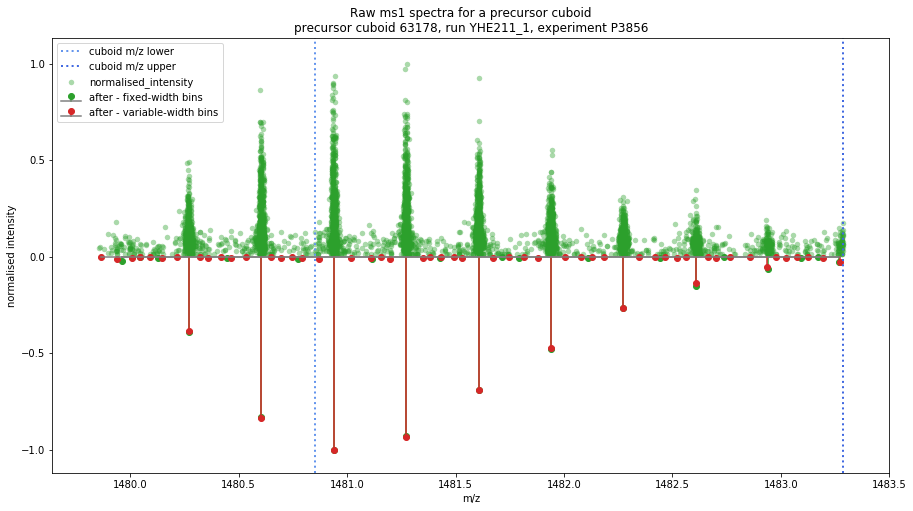

In [197]:
f, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

ax.scatter(before_df.mz, before_df.normalised_intensity, marker='o', color='tab:green', lw=0, s=30, alpha=0.4)

markerline, stemlines, baseline = ax.stem(peaks_fixed_bins_df.mz, -peaks_fixed_bins_df.normalised_intensity, label='after - fixed-width bins')
plt.setp(markerline, 'color', colors[2])
plt.setp(stemlines, 'color', colors[2])
plt.setp(baseline, 'color', colors[7])

markerline, stemlines, baseline = ax.stem(peaks_variable_bins_df.mz, -peaks_variable_bins_df.normalised_intensity, label='after - variable-width bins')
plt.setp(markerline, 'color', colors[3])
plt.setp(stemlines, 'color', colors[3])
plt.setp(baseline, 'color', colors[7])

plt.axvline(x=metadata_s.window_mz_lower, linestyle=':', color='cornflowerblue', linewidth=2, label='cuboid m/z lower')
plt.axvline(x=metadata_s.window_mz_upper, linestyle=':', color='royalblue', linewidth=2, label='cuboid m/z upper')

plt.xlabel('m/z')
plt.ylabel('normalised intensity')
f.set_figheight(8)
f.set_figwidth(15)

nearest = 0.5
range_l = round(before_df.mz.min() / nearest) * nearest
range_u = round(before_df.mz.max() / nearest) * nearest
plt.xticks(np.arange(range_l,range_u+nearest,nearest))

# plt.xlim((1481,1482))

plt.margins(0.06)
plt.legend(loc='best')
plt.title('Raw ms1 spectra for a precursor cuboid\nprecursor cuboid {}, run {}, experiment {}'.format(precursor_id, RUN_NAME, EXPERIMENT_NAME))
plt.show()

#### plot the features after deconvolution of the fixed-width binned data

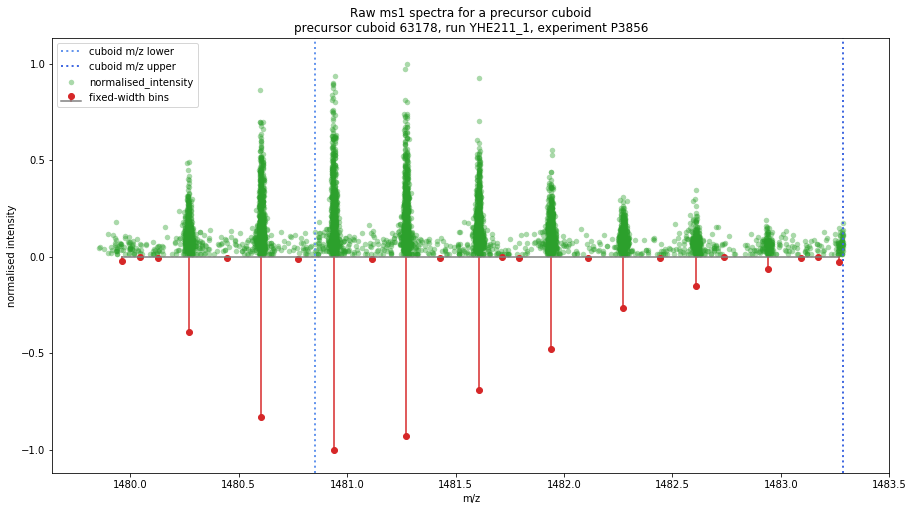

In [198]:
f, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

ax.scatter(before_df.mz, before_df.normalised_intensity, marker='o', color='tab:green', lw=0, s=30, alpha=0.4)

markerline, stemlines, baseline = ax.stem(peaks_fixed_bins_df.mz, -peaks_fixed_bins_df.normalised_intensity, label='fixed-width bins')
plt.setp(markerline, 'color', colors[3])
plt.setp(stemlines, 'color', colors[3])
plt.setp(baseline, 'color', colors[7])

plt.axvline(x=metadata_s.window_mz_lower, linestyle=':', color='cornflowerblue', linewidth=2, label='cuboid m/z lower')
plt.axvline(x=metadata_s.window_mz_upper, linestyle=':', color='royalblue', linewidth=2, label='cuboid m/z upper')

plt.xlabel('m/z')
plt.ylabel('normalised intensity')
f.set_figheight(8)
f.set_figwidth(15)

nearest = 0.5
range_l = round(before_df.mz.min() / nearest) * nearest
range_u = round(before_df.mz.max() / nearest) * nearest
plt.xticks(np.arange(range_l,range_u+nearest,nearest))

plt.margins(0.06)
plt.legend(loc='best')
plt.title('Raw ms1 spectra for a precursor cuboid\nprecursor cuboid {}, run {}, experiment {}'.format(precursor_id, RUN_NAME, EXPERIMENT_NAME))
plt.show()

In [199]:
ms1_peaks_l = list(map(tuple, peaks_fixed_bins_a))
deconvoluted_peaks, _priority_targets = deconvolute_peaks(ms1_peaks_l, use_quick_charge=True, averagine=averagine.peptide, charge_range=(1,5), error_tolerance=5.0, scorer=scoring.MSDeconVFitter(10.0), truncate_after=0.95)

In [200]:
ms1_deconvoluted_peaks_l = []
for peak_idx,peak in enumerate(deconvoluted_peaks):
    # discard a monoisotopic peak that has either of the first two peaks as placeholders (indicated by intensity of 1)
    if ((len(peak.envelope) >= 3) and (peak.envelope[0][1] > 1) and (peak.envelope[1][1] > 1)):
        mono_peak_mz = peak.mz
        mono_intensity = peak.intensity
        second_peak_mz = peak.envelope[1][0]
        ms1_deconvoluted_peaks_l.append((mono_peak_mz, second_peak_mz, mono_intensity, peak.score, peak.signal_to_noise, peak.charge, peak.envelope))
features_fixed_bins_df = pd.DataFrame(ms1_deconvoluted_peaks_l, columns=['mono_mz','second_peak_mz','intensity','score','SN','charge','envelope'])

In [201]:
features_fixed_bins_df

,mono_mz,second_peak_mz,intensity,score,SN,charge,envelope
0,1480.113369,1480.447820,6024.0,105.273732,860.571429,3,"((1480.1288, 736.00), (1480.4478, 955.00), (14..."
1,1480.269894,1480.604346,491675.0,1651.982386,70239.285714,3,"((1480.2714, 41923.00), (1480.6043, 88830.00),..."


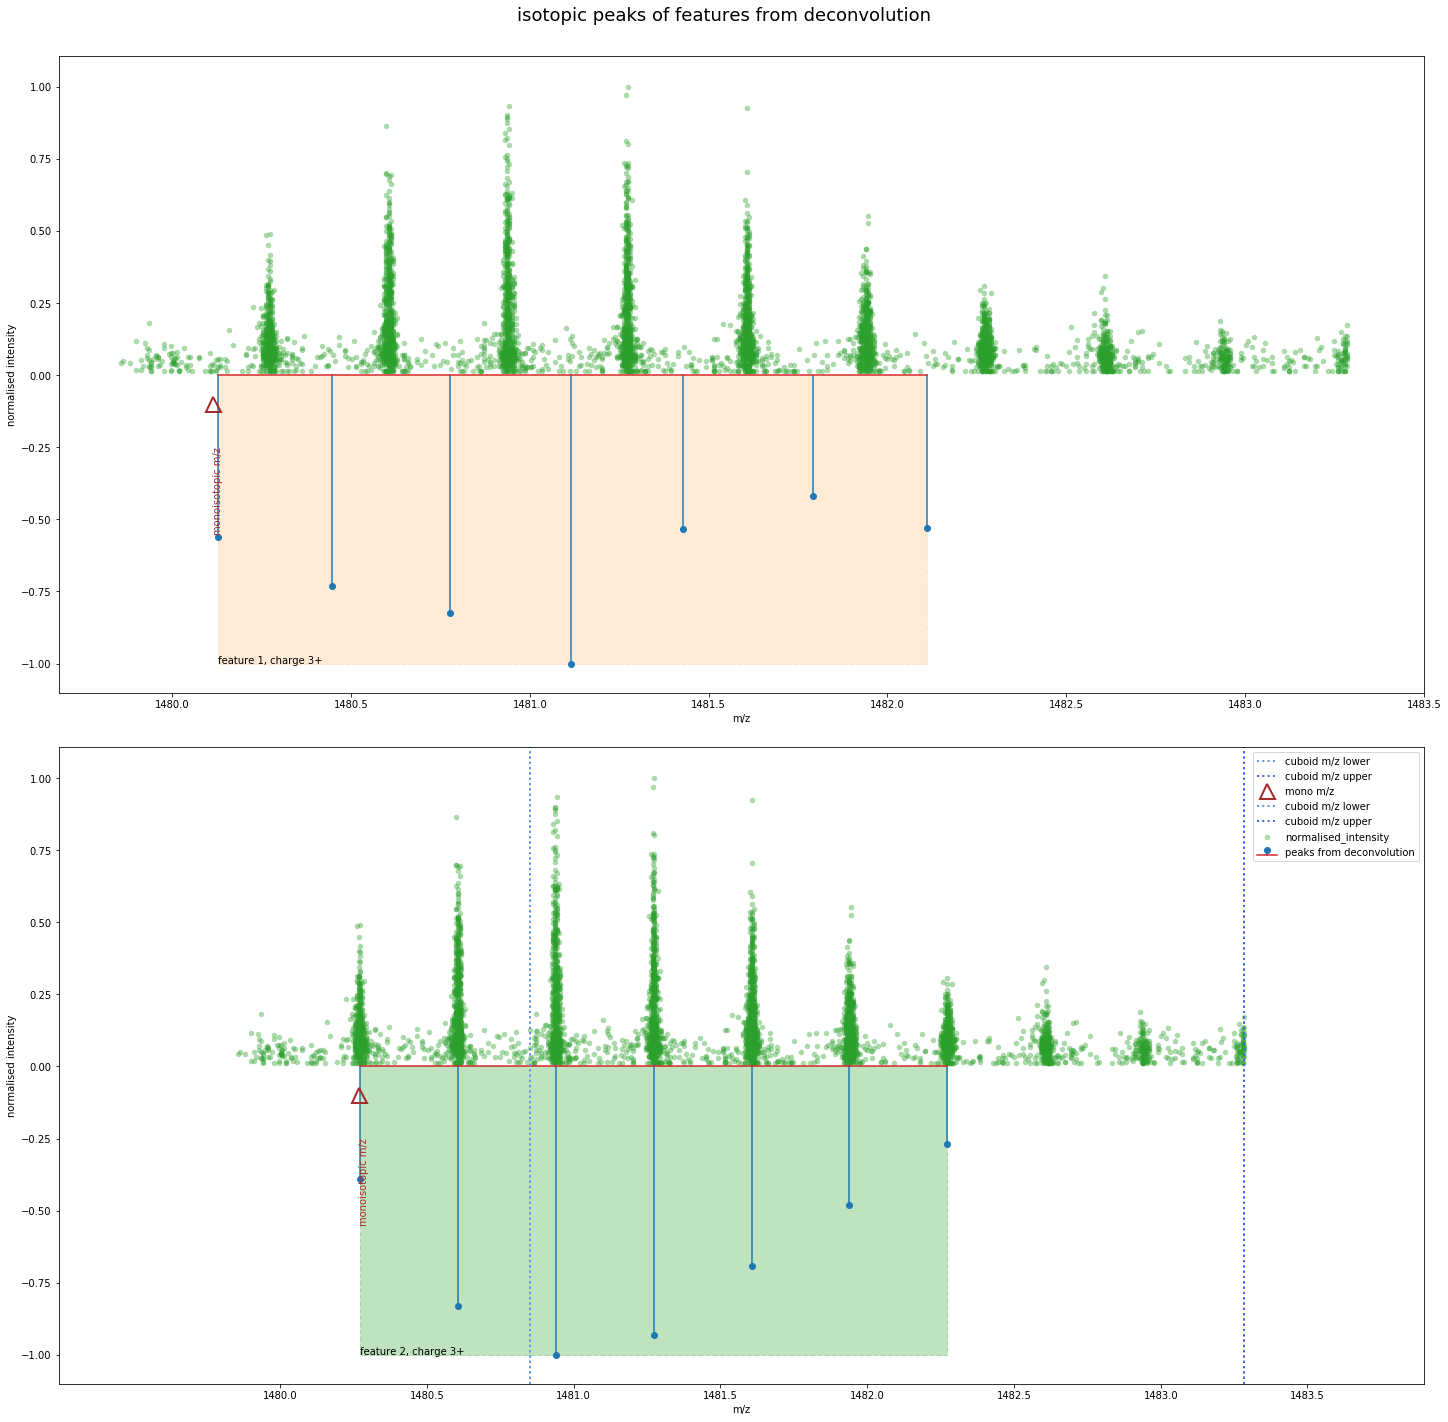

In [202]:
f, axarr = plt.subplots(nrows=len(features_fixed_bins_df), ncols=1, constrained_layout=True)
f.suptitle('isotopic peaks of features from deconvolution\n', fontsize=18)

f.set_figheight(len(features_fixed_bins_df)*10)
f.set_figwidth(20)

# plot the features derived from deconvoluting the peaks
for idx,row in enumerate(features_fixed_bins_df.itertuples()):
    if len(features_fixed_bins_df) > 1:
        ax = axarr[idx]  # row, column
    else:
        ax = axarr

    # plot the raw data
    ax.scatter(before_df.mz, before_df.normalised_intensity, marker='o', color='tab:green', lw=0, s=30, alpha=0.4)

    # plot the feature's bounding rectangle
    envelope = row.envelope
    feature_id = idx+1
    env_width = envelope[-1][0] - envelope[0][0]
    rect_colour = tableau20_mpl[idx+3]
    rect = patches.Rectangle((envelope[0][0],0),env_width,-1.0,linewidth=1,linestyle=(0,(5,2)),edgecolor=rect_colour+(0.3,),facecolor=rect_colour+(0.3,),fill=True)
    ax.add_patch(rect)
    ax.text(x=envelope[0][0], y=-1.0, s='feature {}, charge {}+'.format(feature_id, row.charge))

    # determine the peaks from the envelope
    envelope_df = pd.DataFrame(envelope, columns=['mz','intensity'])
    envelope_df['normalised_intensity'] = envelope_df.intensity / envelope_df.intensity.max()

    # plot the peaks from deconvolution
    markerline, stemlines, baseline = ax.stem(envelope_df.mz, -envelope_df.normalised_intensity, label='peaks from deconvolution')
    
    # show the monoisotopic m/z determined by deconvolution
    ax.plot(row.mono_mz, -0.1, marker='^', markerfacecolor='none', markeredgecolor='brown', linestyle='', markeredgewidth=2, ms=15, label='mono m/z')
    text_style = dict(size=10, color='brown', verticalalignment='center', horizontalalignment='left')
    ax.text(row.mono_mz, -0.4, "monoisotopic m/z", **text_style, rotation='vertical')

    plt.axvline(x=metadata_s.window_mz_lower, linestyle=':', color='cornflowerblue', linewidth=2, label='cuboid m/z lower')
    plt.axvline(x=metadata_s.window_mz_upper, linestyle=':', color='royalblue', linewidth=2, label='cuboid m/z upper')

    nearest = 0.5
    range_l = round(before_df.mz.min() / nearest) * nearest
    range_u = round(before_df.mz.max() / nearest) * nearest
    ax.set_xticks(np.arange(range_l,range_u+nearest,nearest))

    ax.set_xlabel('m/z')
    ax.set_ylabel('normalised intensity')

plt.legend(loc='best')
plt.show()

In [203]:
features_fixed_bins_df

,mono_mz,second_peak_mz,intensity,score,SN,charge,envelope
0,1480.113369,1480.447820,6024.0,105.273732,860.571429,3,"((1480.1288, 736.00), (1480.4478, 955.00), (14..."
1,1480.269894,1480.604346,491675.0,1651.982386,70239.285714,3,"((1480.2714, 41923.00), (1480.6043, 88830.00),..."


#### plot the features after deconvolution of the variable-width binned data

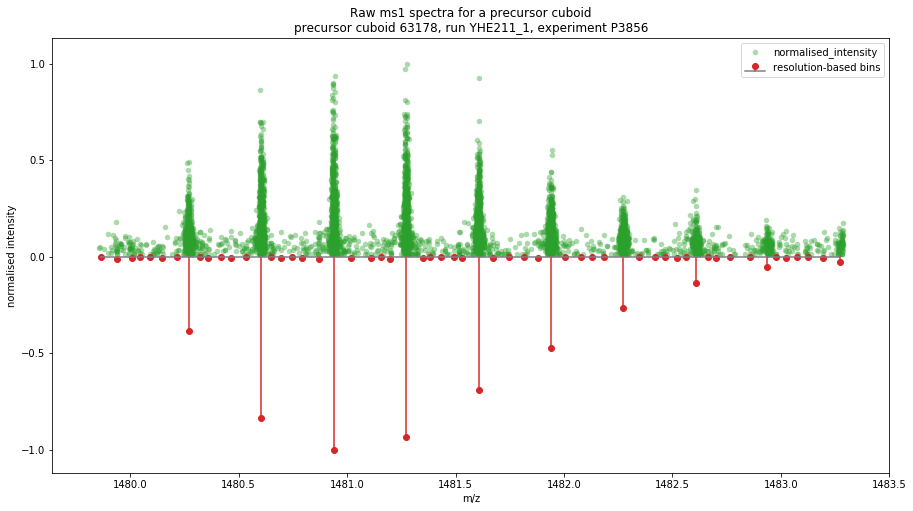

In [204]:
f, ax = plt.subplots()

ax.scatter(before_df.mz, before_df.normalised_intensity, marker='o', color='tab:green', lw=0, s=30, alpha=0.4)

markerline, stemlines, baseline = ax.stem(peaks_variable_bins_df.mz, -peaks_variable_bins_df.normalised_intensity, label='resolution-based bins')
plt.setp(markerline, 'color', colors[3])
plt.setp(stemlines, 'color', colors[3])
plt.setp(baseline, 'color', colors[7])

plt.xlabel('m/z')
plt.ylabel('normalised intensity')
f.set_figheight(8)
f.set_figwidth(15)

nearest = 0.5
range_l = round(before_df.mz.min() / nearest) * nearest
range_u = round(before_df.mz.max() / nearest) * nearest
plt.xticks(np.arange(range_l,range_u+nearest,nearest))

plt.margins(0.06)
plt.legend(loc='best')
plt.title('Raw ms1 spectra for a precursor cuboid\nprecursor cuboid {}, run {}, experiment {}'.format(precursor_id, RUN_NAME, EXPERIMENT_NAME))
plt.show()

In [205]:
ms1_peaks_l = list(map(tuple, peaks_variable_bins_a))
deconvoluted_peaks, _priority_targets = deconvolute_peaks(ms1_peaks_l, use_quick_charge=True, averagine=averagine.peptide, charge_range=(1,5), error_tolerance=5.0, scorer=scoring.MSDeconVFitter(10.0), truncate_after=0.95)

In [206]:
ms1_deconvoluted_peaks_l = []
for peak_idx,peak in enumerate(deconvoluted_peaks):
    # discard a monoisotopic peak that has either of the first two peaks as placeholders (indicated by intensity of 1)
    if ((len(peak.envelope) >= 3) and (peak.envelope[0][1] > 1) and (peak.envelope[1][1] > 1)):
        mono_peak_mz = peak.mz
        mono_intensity = peak.intensity
        second_peak_mz = peak.envelope[1][0]
        ms1_deconvoluted_peaks_l.append((mono_peak_mz, second_peak_mz, mono_intensity, peak.score, peak.signal_to_noise, peak.charge, peak.envelope))
features_variable_bins_df = pd.DataFrame(ms1_deconvoluted_peaks_l, columns=['mono_mz','second_peak_mz','intensity','score','SN','charge','envelope'])

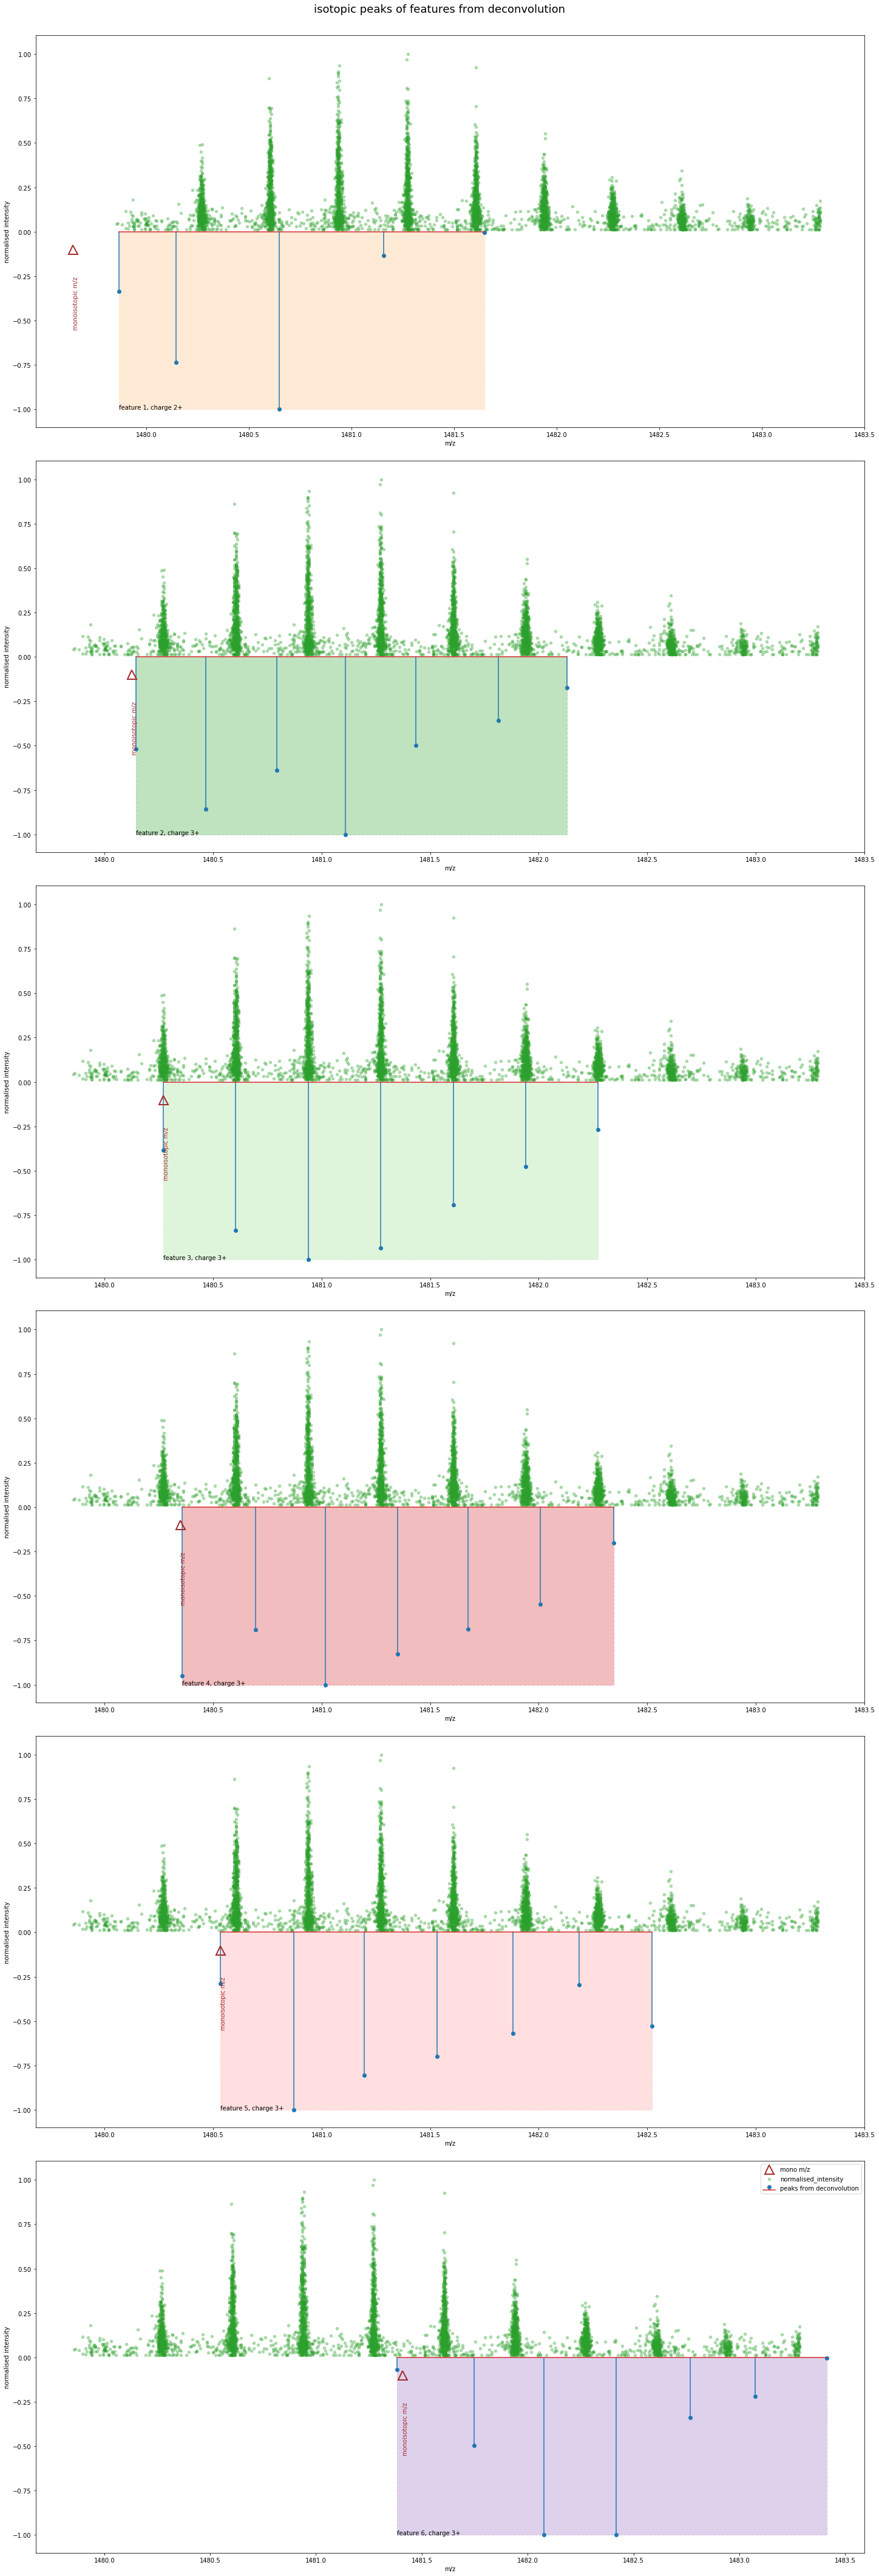

In [207]:
f, axarr = plt.subplots(nrows=len(features_variable_bins_df), ncols=1, constrained_layout=True)
f.suptitle('isotopic peaks of features from deconvolution\n', fontsize=18)

f.set_figheight(len(features_variable_bins_df)*10)
f.set_figwidth(20)

# plot the features derived from deconvoluting the peaks
for idx,row in enumerate(features_variable_bins_df.itertuples()):
    if len(features_variable_bins_df) > 1:
        ax = axarr[idx]  # row, column
    else:
        ax = axarr

    # plot the raw data
    ax.scatter(before_df.mz, before_df.normalised_intensity, marker='o', color='tab:green', lw=0, s=30, alpha=0.4)

    # plot the feature's bounding rectangle
    envelope = row.envelope
    feature_id = idx+1
    env_width = envelope[-1][0] - envelope[0][0]
    rect_colour = tableau20_mpl[idx+3]
    rect = patches.Rectangle((envelope[0][0],0),env_width,-1.0,linewidth=1,linestyle=(0,(5,2)),edgecolor=rect_colour+(0.3,),facecolor=rect_colour+(0.3,),fill=True)
    ax.add_patch(rect)
    ax.text(x=envelope[0][0], y=-1.0, s='feature {}, charge {}+'.format(feature_id, row.charge))

    # determine the peaks from the envelope
    envelope_df = pd.DataFrame(envelope, columns=['mz','intensity'])
    envelope_df['normalised_intensity'] = envelope_df.intensity / envelope_df.intensity.max()

    # plot the peaks from deconvolution
    markerline, stemlines, baseline = ax.stem(envelope_df.mz, -envelope_df.normalised_intensity, label='peaks from deconvolution')
    
    # show the monoisotopic m/z determined by deconvolution
    ax.plot(row.mono_mz, -0.1, marker='^', markerfacecolor='none', markeredgecolor='brown', linestyle='', markeredgewidth=2, ms=15, label='mono m/z')
    text_style = dict(size=10, color='brown', verticalalignment='center', horizontalalignment='left')
    ax.text(row.mono_mz, -0.4, "monoisotopic m/z", **text_style, rotation='vertical')

    nearest = 0.5
    range_l = round(before_df.mz.min() / nearest) * nearest
    range_u = round(before_df.mz.max() / nearest) * nearest
    ax.set_xticks(np.arange(range_l,range_u+nearest,nearest))

    ax.set_xlabel('m/z')
    ax.set_ylabel('normalised intensity')

plt.legend(loc='best')
plt.show()

In [208]:
features_variable_bins_df

,mono_mz,second_peak_mz,intensity,score,SN,charge,envelope
0,1479.643778,1480.144609,610.788444,21.915930,229.250000,2,"((1479.8664, 93.00), (1480.1446, 203.79), (148..."
1,1480.125454,1480.466659,3982.000000,48.283342,568.857143,3,"((1480.1446, 510.00), (1480.4667, 842.00), (14..."
2,1480.269929,1480.604381,482079.000000,1659.654589,68868.428571,3,"((1480.2703, 40432.00), (1480.6044, 87663.00),..."
3,1480.348687,1480.694164,4295.000000,87.476695,613.571429,3,"((1480.3570, 831.00), (1480.6942, 605.00), (14..."
4,1480.532402,1480.870310,5827.000000,102.408225,832.428571,3,"((1480.5324, 400.00), (1480.8703, 1392.00), (1..."
5,1481.407873,1481.746005,1349.000000,41.115232,224.833333,3,"((1481.3835, 30.00), (1481.7460, 215.00), (148..."
